In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================

def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set, one_hot=True)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = 0
    for column,dim in discrete_column_dims.items():
        if dim == 2:
            num_discrete_columns+=1
        else:
            num_discrete_columns+= dim
            
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    print('Num real columns :: ', num_real_columns)
    print('Num discrete columns ::', num_discrete_columns)
    
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns 
    for k,v in discrete_column_dims.items():
        if v == 2:
            v = 1
        final_op_dims +=  v
        
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim


In [4]:
def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.05
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

def test(
    dagmm_obj,
    data_dict
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

    test_X = data_dict['test'].values
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())

    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
  
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    num_anom_sets = 5
    for idx in range(1,num_anom_sets+1):
        key = 'anom_' + str(idx)
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1

        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
        print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
        print(
            combined_energy.shape,
            combined_labels.shape
        )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending= False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step
        P = [P[0]] + P
        from sklearn.metrics import auc
        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
    print(' Mean AUC ',np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return


In [5]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [6]:
# =================================== #
data_set = 'nb15'
data_dict, _ = data_fetcher.get_data(data_set,True,anomaly_ratio=0.1,num_anom_sets=5)
train_df = data_dict['train']
train_X = train_df.values

In [8]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Num real columns ::  37
Num discrete columns :: 157
{'discrete_column_dims': {'is_ftp_login': 3,
                          'is_sm_ips_ports': 2,
                          'proto': 133,
                          'service': 11,
                          'state': 9},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [60, 30, 10, 1]},
 'num_discrete': 157,
 'num_real': 37}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 10, 30, 60, 194]},
 'discrete_column_dims': {'is_ftp_login': 3,
                          'is_sm_ips_ports': 2,
                          'proto': 133,
                          'service': 11,
                          'state': 9},
 'final_output_dim': 194,
 'num_discrete': 157,
 'num_real': 37}


In [9]:
gmm_structure_config

{'num_components': 3,
 'FC_layer_dims': [3, 10, 3],
 'FC_dropout': 0.5,
 'FC_activation': 'tanh'}

In [10]:
   
dagmm_obj = DaGMM(
    DEVICE,
    encoder_structure_config,
    decoder_structure_config,
    n_gmm=gmm_structure_config['num_components'],
    ae_latent_dim=1
)
dagmm_obj = dagmm_obj.to(DEVICE)
print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=194, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): Tanh()
      (6): Linear(in_features=60, out_features=194, bias=True)
      (7): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=3, bias=True)
    (4): Softmax(dim=1)
  )
)


In [15]:
dagmm_obj = train(
    dagmm_obj,
    train_X,
    num_epochs=200,
    batch_size=1024
)

  0%|          | 1/200 [00:01<05:08,  1.55s/it]

Epoch loss :: 146.94444


  1%|          | 2/200 [00:03<05:07,  1.55s/it]

Epoch loss :: 146.78044


  2%|▏         | 3/200 [00:04<04:53,  1.49s/it]

Epoch loss :: 146.62376


  2%|▏         | 4/200 [00:05<04:46,  1.46s/it]

Epoch loss :: 146.54436


  2%|▎         | 5/200 [00:07<04:37,  1.42s/it]

Epoch loss :: 146.51756


  3%|▎         | 6/200 [00:08<04:32,  1.40s/it]

Epoch loss :: 146.59726


  4%|▎         | 7/200 [00:09<04:26,  1.38s/it]

Epoch loss :: 147.03705


  4%|▍         | 8/200 [00:11<04:27,  1.39s/it]

Epoch loss :: 146.49937


  4%|▍         | 9/200 [00:12<04:28,  1.40s/it]

Epoch loss :: 146.96748


  5%|▌         | 10/200 [00:13<04:16,  1.35s/it]

Epoch loss :: 147.11974


  6%|▌         | 11/200 [00:15<04:31,  1.44s/it]

Epoch loss :: 146.7724


  6%|▌         | 12/200 [00:17<04:35,  1.47s/it]

Epoch loss :: 147.12259


  6%|▋         | 13/200 [00:18<04:38,  1.49s/it]

Epoch loss :: 146.52193


  7%|▋         | 14/200 [00:20<04:45,  1.53s/it]

Epoch loss :: 146.71024


  8%|▊         | 15/200 [00:21<04:34,  1.48s/it]

Epoch loss :: 146.61807


  8%|▊         | 16/200 [00:23<04:45,  1.55s/it]

Epoch loss :: 146.5052


  8%|▊         | 17/200 [00:25<04:48,  1.58s/it]

Epoch loss :: 147.06699


  9%|▉         | 18/200 [00:26<04:45,  1.57s/it]

Epoch loss :: 146.2904


 10%|▉         | 19/200 [00:28<04:39,  1.54s/it]

Epoch loss :: 146.64818


 10%|█         | 20/200 [00:29<04:39,  1.55s/it]

Epoch loss :: 146.88905


 10%|█         | 21/200 [00:31<04:37,  1.55s/it]

Epoch loss :: 146.74599


 11%|█         | 22/200 [00:32<04:43,  1.59s/it]

Epoch loss :: 147.07144


 12%|█▏        | 23/200 [00:34<04:35,  1.56s/it]

Epoch loss :: 146.68335


 12%|█▏        | 24/200 [00:35<04:37,  1.58s/it]

Epoch loss :: 146.95567


 12%|█▎        | 25/200 [00:37<04:33,  1.57s/it]

Epoch loss :: 147.00539


 13%|█▎        | 26/200 [00:39<04:29,  1.55s/it]

Epoch loss :: 146.47945


 14%|█▎        | 27/200 [00:40<04:21,  1.51s/it]

Epoch loss :: 146.28621


 14%|█▍        | 28/200 [00:41<04:18,  1.50s/it]

Epoch loss :: 146.29507


 14%|█▍        | 29/200 [00:43<04:11,  1.47s/it]

Epoch loss :: 146.70006


 15%|█▌        | 30/200 [00:44<04:17,  1.51s/it]

Epoch loss :: 146.36577


 16%|█▌        | 31/200 [00:46<04:07,  1.47s/it]

Epoch loss :: 147.37625


 16%|█▌        | 32/200 [00:47<04:04,  1.46s/it]

Epoch loss :: 146.5459


 16%|█▋        | 33/200 [00:49<04:08,  1.49s/it]

Epoch loss :: 146.73373


 17%|█▋        | 34/200 [00:50<04:04,  1.47s/it]

Epoch loss :: 147.0195


 18%|█▊        | 35/200 [00:52<04:03,  1.48s/it]

Epoch loss :: 146.35834


 18%|█▊        | 36/200 [00:53<03:50,  1.41s/it]

Epoch loss :: 146.71828


 18%|█▊        | 37/200 [00:54<03:48,  1.40s/it]

Epoch loss :: 146.52759


 19%|█▉        | 38/200 [00:56<04:04,  1.51s/it]

Epoch loss :: 146.93683


 20%|█▉        | 39/200 [00:58<04:05,  1.52s/it]

Epoch loss :: 146.94786


 20%|██        | 40/200 [00:59<04:11,  1.57s/it]

Epoch loss :: 146.8193


 20%|██        | 41/200 [01:01<04:10,  1.58s/it]

Epoch loss :: 146.53903


 21%|██        | 42/200 [01:02<04:08,  1.58s/it]

Epoch loss :: 146.59106


 22%|██▏       | 43/200 [01:04<04:07,  1.58s/it]

Epoch loss :: 146.40276


 22%|██▏       | 44/200 [01:06<04:03,  1.56s/it]

Epoch loss :: 146.58516


 22%|██▎       | 45/200 [01:07<04:02,  1.57s/it]

Epoch loss :: 146.9705


 23%|██▎       | 46/200 [01:09<04:09,  1.62s/it]

Epoch loss :: 146.57855


 24%|██▎       | 47/200 [01:11<04:07,  1.62s/it]

Epoch loss :: 147.04745


 24%|██▍       | 48/200 [01:12<04:09,  1.64s/it]

Epoch loss :: 146.78957


 24%|██▍       | 49/200 [01:14<04:06,  1.64s/it]

Epoch loss :: 146.60878


 25%|██▌       | 50/200 [01:15<03:55,  1.57s/it]

Epoch loss :: 146.5676


 26%|██▌       | 51/200 [01:17<03:59,  1.60s/it]

Epoch loss :: 146.67665


 26%|██▌       | 52/200 [01:18<03:24,  1.38s/it]

Epoch loss :: 146.82521


 26%|██▋       | 53/200 [01:20<03:36,  1.48s/it]

Epoch loss :: 146.72144


 27%|██▋       | 54/200 [01:21<03:44,  1.54s/it]

Epoch loss :: 146.67923


 28%|██▊       | 55/200 [01:23<03:53,  1.61s/it]

Epoch loss :: 146.99316


 28%|██▊       | 56/200 [01:25<03:52,  1.61s/it]

Epoch loss :: 147.3426


 28%|██▊       | 57/200 [01:26<03:56,  1.65s/it]

Epoch loss :: 147.69647


 29%|██▉       | 58/200 [01:28<03:56,  1.67s/it]

Epoch loss :: 146.99013


 30%|██▉       | 59/200 [01:29<03:46,  1.60s/it]

Epoch loss :: 146.847


 30%|███       | 60/200 [01:31<03:40,  1.57s/it]

Epoch loss :: 146.88159


 30%|███       | 61/200 [01:33<03:43,  1.61s/it]

Epoch loss :: 146.6012


 31%|███       | 62/200 [01:34<03:46,  1.64s/it]

Epoch loss :: 146.80325


 32%|███▏      | 63/200 [01:36<03:37,  1.58s/it]

Epoch loss :: 146.42282


 32%|███▏      | 64/200 [01:37<03:35,  1.58s/it]

Epoch loss :: 146.78412


 32%|███▎      | 65/200 [01:39<03:21,  1.50s/it]

Epoch loss :: 146.84647


 33%|███▎      | 66/200 [01:40<03:29,  1.57s/it]

Epoch loss :: 146.72394


 34%|███▎      | 67/200 [01:42<03:34,  1.61s/it]

Epoch loss :: 147.23332


 34%|███▍      | 68/200 [01:44<03:39,  1.66s/it]

Epoch loss :: 146.60736


 34%|███▍      | 69/200 [01:46<03:40,  1.68s/it]

Epoch loss :: 147.2768


 35%|███▌      | 70/200 [01:47<03:36,  1.66s/it]

Epoch loss :: 146.59486


 36%|███▌      | 71/200 [01:49<03:29,  1.63s/it]

Epoch loss :: 146.67209


 36%|███▌      | 72/200 [01:50<03:19,  1.56s/it]

Epoch loss :: 146.6339


 36%|███▋      | 73/200 [01:52<03:16,  1.55s/it]

Epoch loss :: 146.3449


 37%|███▋      | 74/200 [01:53<03:13,  1.54s/it]

Epoch loss :: 146.82568


 38%|███▊      | 75/200 [01:55<03:08,  1.51s/it]

Epoch loss :: 146.54466


 38%|███▊      | 76/200 [01:56<03:11,  1.54s/it]

Epoch loss :: 146.92659


 38%|███▊      | 77/200 [01:58<03:05,  1.50s/it]

Epoch loss :: 147.28758


 39%|███▉      | 78/200 [01:59<02:59,  1.47s/it]

Epoch loss :: 146.60522


 40%|███▉      | 79/200 [02:01<02:57,  1.47s/it]

Epoch loss :: 147.01445


 40%|████      | 80/200 [02:02<02:57,  1.48s/it]

Epoch loss :: 146.74118


 40%|████      | 81/200 [02:04<02:53,  1.46s/it]

Epoch loss :: 146.63211


 41%|████      | 82/200 [02:05<02:59,  1.52s/it]

Epoch loss :: 146.87271


 42%|████▏     | 83/200 [02:07<02:58,  1.53s/it]

Epoch loss :: 146.48141


 42%|████▏     | 84/200 [02:08<02:57,  1.53s/it]

Epoch loss :: 146.65134


 42%|████▎     | 85/200 [02:10<02:57,  1.54s/it]

Epoch loss :: 146.62296


 43%|████▎     | 86/200 [02:11<02:51,  1.51s/it]

Epoch loss :: 147.15155


 44%|████▎     | 87/200 [02:13<02:53,  1.54s/it]

Epoch loss :: 146.92802


 44%|████▍     | 88/200 [02:14<02:43,  1.46s/it]

Epoch loss :: 146.34946


 44%|████▍     | 89/200 [02:16<02:52,  1.55s/it]

Epoch loss :: 146.74153


 45%|████▌     | 90/200 [02:18<02:57,  1.61s/it]

Epoch loss :: 146.58212


 46%|████▌     | 91/200 [02:19<02:59,  1.65s/it]

Epoch loss :: 146.78265


 46%|████▌     | 92/200 [02:21<02:54,  1.62s/it]

Epoch loss :: 146.34016


 46%|████▋     | 93/200 [02:23<02:57,  1.66s/it]

Epoch loss :: 146.5518


 47%|████▋     | 94/200 [02:24<02:58,  1.69s/it]

Epoch loss :: 146.7428


 48%|████▊     | 95/200 [02:26<02:59,  1.71s/it]

Epoch loss :: 147.02061


 48%|████▊     | 96/200 [02:28<02:56,  1.70s/it]

Epoch loss :: 146.90552


 48%|████▊     | 97/200 [02:30<02:55,  1.70s/it]

Epoch loss :: 146.38676


 49%|████▉     | 98/200 [02:31<02:51,  1.68s/it]

Epoch loss :: 146.56828


 50%|████▉     | 99/200 [02:33<02:41,  1.60s/it]

Epoch loss :: 146.41605


 50%|█████     | 100/200 [02:34<02:40,  1.60s/it]

Epoch loss :: 147.39836


 50%|█████     | 101/200 [02:36<02:30,  1.52s/it]

Epoch loss :: 146.77629


 51%|█████     | 102/200 [02:37<02:35,  1.58s/it]

Epoch loss :: 146.87038


 52%|█████▏    | 103/200 [02:39<02:37,  1.62s/it]

Epoch loss :: 146.80458


 52%|█████▏    | 104/200 [02:41<02:35,  1.61s/it]

Epoch loss :: 146.20958


 52%|█████▎    | 105/200 [02:42<02:28,  1.56s/it]

Epoch loss :: 146.87029


 53%|█████▎    | 106/200 [02:44<02:30,  1.60s/it]

Epoch loss :: 147.04831


 54%|█████▎    | 107/200 [02:45<02:31,  1.63s/it]

Epoch loss :: 146.4621


 54%|█████▍    | 108/200 [02:47<02:29,  1.62s/it]

Epoch loss :: 147.14833


 55%|█████▍    | 109/200 [02:49<02:23,  1.58s/it]

Epoch loss :: 146.37518


 55%|█████▌    | 110/200 [02:50<02:26,  1.63s/it]

Epoch loss :: 146.78018


 56%|█████▌    | 111/200 [02:52<02:18,  1.56s/it]

Epoch loss :: 146.76956


 56%|█████▌    | 112/200 [02:53<02:15,  1.54s/it]

Epoch loss :: 146.50734


 56%|█████▋    | 113/200 [02:55<02:11,  1.51s/it]

Epoch loss :: 146.72374


 57%|█████▋    | 114/200 [02:56<02:10,  1.52s/it]

Epoch loss :: 146.47673


 57%|█████▊    | 115/200 [02:58<02:07,  1.50s/it]

Epoch loss :: 146.74774


 58%|█████▊    | 116/200 [02:59<02:03,  1.48s/it]

Epoch loss :: 146.76622


 58%|█████▊    | 117/200 [03:00<02:02,  1.47s/it]

Epoch loss :: 146.62524


 59%|█████▉    | 118/200 [03:02<02:03,  1.50s/it]

Epoch loss :: 146.59096


 60%|█████▉    | 119/200 [03:04<02:02,  1.51s/it]

Epoch loss :: 146.25513


 60%|██████    | 120/200 [03:05<02:01,  1.51s/it]

Epoch loss :: 146.71754


 60%|██████    | 121/200 [03:07<01:59,  1.51s/it]

Epoch loss :: 146.41713


 61%|██████    | 122/200 [03:08<01:56,  1.49s/it]

Epoch loss :: 146.82407


 62%|██████▏   | 123/200 [03:10<01:53,  1.47s/it]

Epoch loss :: 146.7835


 62%|██████▏   | 124/200 [03:11<01:51,  1.47s/it]

Epoch loss :: 146.6687


 62%|██████▎   | 125/200 [03:12<01:48,  1.45s/it]

Epoch loss :: 146.42117


 63%|██████▎   | 126/200 [03:14<01:50,  1.49s/it]

Epoch loss :: 146.72388


 64%|██████▎   | 127/200 [03:16<01:50,  1.51s/it]

Epoch loss :: 146.77515


 64%|██████▍   | 128/200 [03:17<01:46,  1.48s/it]

Epoch loss :: 146.43962


 64%|██████▍   | 129/200 [03:18<01:43,  1.46s/it]

Epoch loss :: 146.66856


 65%|██████▌   | 130/200 [03:20<01:42,  1.47s/it]

Epoch loss :: 146.70407


 66%|██████▌   | 131/200 [03:21<01:40,  1.45s/it]

Epoch loss :: 146.51431


 66%|██████▌   | 132/200 [03:23<01:38,  1.45s/it]

Epoch loss :: 146.84184


 66%|██████▋   | 133/200 [03:24<01:42,  1.53s/it]

Epoch loss :: 146.93968


 67%|██████▋   | 134/200 [03:26<01:39,  1.51s/it]

Epoch loss :: 146.68484


 68%|██████▊   | 135/200 [03:27<01:40,  1.54s/it]

Epoch loss :: 146.86987


 68%|██████▊   | 136/200 [03:29<01:37,  1.53s/it]

Epoch loss :: 146.72868


 68%|██████▊   | 137/200 [03:31<01:36,  1.53s/it]

Epoch loss :: 146.78288


 69%|██████▉   | 138/200 [03:32<01:35,  1.55s/it]

Epoch loss :: 146.78136


 70%|██████▉   | 139/200 [03:34<01:37,  1.59s/it]

Epoch loss :: 146.70844


 70%|███████   | 140/200 [03:35<01:34,  1.58s/it]

Epoch loss :: 146.43217


 70%|███████   | 141/200 [03:37<01:32,  1.57s/it]

Epoch loss :: 146.62666


 71%|███████   | 142/200 [03:38<01:28,  1.52s/it]

Epoch loss :: 146.54971


 72%|███████▏  | 143/200 [03:40<01:26,  1.52s/it]

Epoch loss :: 146.48077


 72%|███████▏  | 144/200 [03:41<01:23,  1.49s/it]

Epoch loss :: 146.45706


 72%|███████▎  | 145/200 [03:43<01:20,  1.47s/it]

Epoch loss :: 146.40564


 73%|███████▎  | 146/200 [03:44<01:23,  1.54s/it]

Epoch loss :: 146.60788


 74%|███████▎  | 147/200 [03:46<01:22,  1.55s/it]

Epoch loss :: 146.81213


 74%|███████▍  | 148/200 [03:47<01:20,  1.55s/it]

Epoch loss :: 146.68526


 74%|███████▍  | 149/200 [03:49<01:19,  1.56s/it]

Epoch loss :: 146.70915


 75%|███████▌  | 150/200 [03:51<01:19,  1.59s/it]

Epoch loss :: 147.16292


 76%|███████▌  | 151/200 [03:52<01:19,  1.63s/it]

Epoch loss :: 146.62791


 76%|███████▌  | 152/200 [03:54<01:16,  1.59s/it]

Epoch loss :: 146.32697


 76%|███████▋  | 153/200 [03:56<01:16,  1.62s/it]

Epoch loss :: 146.37773


 77%|███████▋  | 154/200 [03:57<01:12,  1.58s/it]

Epoch loss :: 146.88704


 78%|███████▊  | 155/200 [03:59<01:10,  1.57s/it]

Epoch loss :: 146.51158


 78%|███████▊  | 156/200 [04:00<01:06,  1.51s/it]

Epoch loss :: 146.67398


 78%|███████▊  | 157/200 [04:02<01:05,  1.52s/it]

Epoch loss :: 146.61613


 79%|███████▉  | 158/200 [04:03<01:01,  1.46s/it]

Epoch loss :: 146.46893


 80%|███████▉  | 159/200 [04:04<00:59,  1.46s/it]

Epoch loss :: 146.66324


 80%|████████  | 160/200 [04:06<00:57,  1.43s/it]

Epoch loss :: 146.83974


 80%|████████  | 161/200 [04:07<00:56,  1.44s/it]

Epoch loss :: 146.71109


 81%|████████  | 162/200 [04:09<00:54,  1.44s/it]

Epoch loss :: 146.46925


 82%|████████▏ | 163/200 [04:10<00:55,  1.49s/it]

Epoch loss :: 146.98874


 82%|████████▏ | 164/200 [04:12<00:53,  1.49s/it]

Epoch loss :: 146.46283


 82%|████████▎ | 165/200 [04:13<00:51,  1.47s/it]

Epoch loss :: 146.48302


 83%|████████▎ | 166/200 [04:15<00:50,  1.47s/it]

Epoch loss :: 146.79916


 84%|████████▎ | 167/200 [04:16<00:49,  1.49s/it]

Epoch loss :: 146.93929


 84%|████████▍ | 168/200 [04:18<00:47,  1.48s/it]

Epoch loss :: 146.84924


 84%|████████▍ | 169/200 [04:19<00:44,  1.44s/it]

Epoch loss :: 146.92519


 85%|████████▌ | 170/200 [04:20<00:42,  1.42s/it]

Epoch loss :: 146.49625


 86%|████████▌ | 171/200 [04:22<00:42,  1.47s/it]

Epoch loss :: 146.86543


 86%|████████▌ | 172/200 [04:23<00:40,  1.45s/it]

Epoch loss :: 146.66139


 86%|████████▋ | 173/200 [04:25<00:40,  1.50s/it]

Epoch loss :: 147.20944


 87%|████████▋ | 174/200 [04:26<00:38,  1.49s/it]

Epoch loss :: 146.54936


 88%|████████▊ | 175/200 [04:28<00:36,  1.45s/it]

Epoch loss :: 147.11414


 88%|████████▊ | 176/200 [04:30<00:37,  1.54s/it]

Epoch loss :: 146.63531


 88%|████████▊ | 177/200 [04:31<00:36,  1.59s/it]

Epoch loss :: 146.54094


 89%|████████▉ | 178/200 [04:33<00:33,  1.55s/it]

Epoch loss :: 146.26494


 90%|████████▉ | 179/200 [04:34<00:33,  1.58s/it]

Epoch loss :: 146.39603


 90%|█████████ | 180/200 [04:36<00:31,  1.57s/it]

Epoch loss :: 147.08095


 90%|█████████ | 181/200 [04:37<00:30,  1.58s/it]

Epoch loss :: 146.56


 91%|█████████ | 182/200 [04:39<00:28,  1.57s/it]

Epoch loss :: 146.58226


 92%|█████████▏| 183/200 [04:40<00:25,  1.52s/it]

Epoch loss :: 146.83339


 92%|█████████▏| 184/200 [04:42<00:24,  1.51s/it]

Epoch loss :: 146.9955


 92%|█████████▎| 185/200 [04:43<00:22,  1.50s/it]

Epoch loss :: 146.69261


 93%|█████████▎| 186/200 [04:45<00:20,  1.46s/it]

Epoch loss :: 146.65585


 94%|█████████▎| 187/200 [04:46<00:18,  1.44s/it]

Epoch loss :: 146.58122


 94%|█████████▍| 188/200 [04:48<00:17,  1.45s/it]

Epoch loss :: 146.54645


 94%|█████████▍| 189/200 [04:49<00:16,  1.50s/it]

Epoch loss :: 146.27428


 95%|█████████▌| 190/200 [04:51<00:15,  1.53s/it]

Epoch loss :: 146.94688


 96%|█████████▌| 191/200 [04:52<00:13,  1.55s/it]

Epoch loss :: 146.92363


 96%|█████████▌| 192/200 [04:54<00:12,  1.52s/it]

Epoch loss :: 146.5494


 96%|█████████▋| 193/200 [04:55<00:10,  1.52s/it]

Epoch loss :: 147.53519


 97%|█████████▋| 194/200 [04:57<00:09,  1.54s/it]

Epoch loss :: 146.60272


 98%|█████████▊| 195/200 [04:58<00:07,  1.53s/it]

Epoch loss :: 146.59546


 98%|█████████▊| 196/200 [05:00<00:06,  1.52s/it]

Epoch loss :: 146.66249


 98%|█████████▊| 197/200 [05:01<00:04,  1.49s/it]

Epoch loss :: 146.88


 99%|█████████▉| 198/200 [05:03<00:03,  1.50s/it]

Epoch loss :: 146.29005


100%|█████████▉| 199/200 [05:05<00:01,  1.53s/it]

Epoch loss :: 146.69904


100%|██████████| 200/200 [05:06<00:00,  1.53s/it]

Epoch loss :: 146.74928


======================TEST MODE======================
N: 39200
phi : tensor([0.2680, 0.3146, 0.4174], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.0234,  1.1744,  0.1065],
        [-0.0234,  1.1744,  0.1067],
        [-0.0235,  1.1742,  0.1064]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[0.0001, 0.0004, 0.0002],
         [0.0004, 0.0022, 0.0004],
         [0.0002, 0.0004, 0.0009]],

        [[0.0001, 0.0004, 0.0002],
         [0.0004, 0.0022, 0.0004],
         [0.0002, 0.0004, 0.0009]],

        [[0.0001, 0.0004, 0.0002],
         [0.0004, 0.0022, 0.0004],
         [0.0002, 0.0004, 0.0009]]], device='cuda:0', grad_fn=<DivBackward0>)
Size of test  16800
test_energy (16800,)
(1680,)
(18480,) (18480,)
AUC : 0.1373 


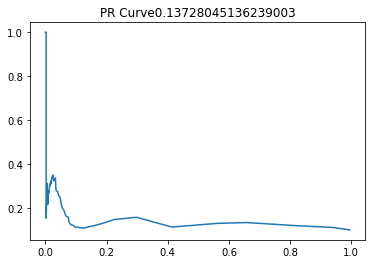

(1680,)
(18480,) (18480,)
AUC : 0.1379 


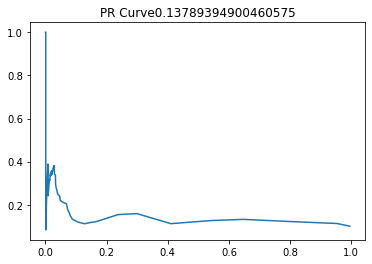

(1680,)
(18480,) (18480,)
AUC : 0.1391 


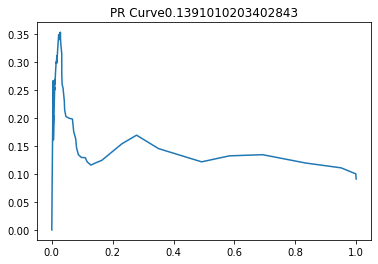

(1680,)
(18480,) (18480,)
AUC : 0.1390 


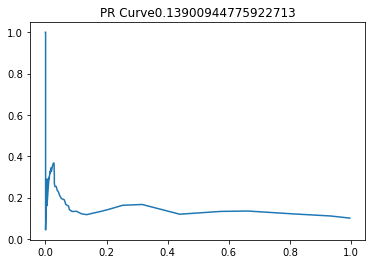

(1680,)
(18480,) (18480,)
AUC : 0.1365 


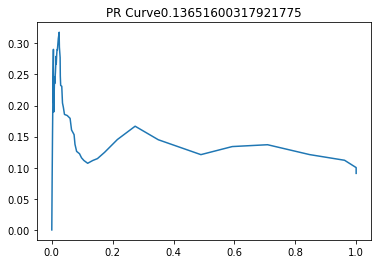

 Mean AUC  0.137960174329145
 AUC std 0.0009954439981872878


In [11]:
test(
    dagmm_obj,
    data_dict
)

In [17]:
0.039

0.039